In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from numpy.linalg import inv

%matplotlib inline

Data Generation
---

Split Training & Testing Data
---

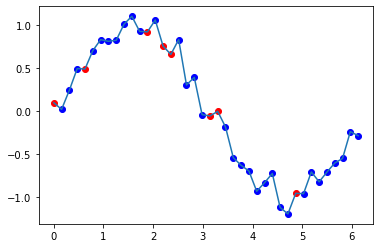

In [279]:
def gen_data(nsamp=40,noise_stdev=0.1,seed=0):
    
    random.seed(seed)
    x = np.arange(0, 2*np.pi, 2*np.pi/nsamp)
    t = []
    for val in x:
        t.append(np.sin(val) + random.gauss(0,noise_stdev))
    t = np.asarray(t)
    
    return x,t

def split_data(x,t,training_size=0.8):

    #Identifies indices to split data by
    data_index = np.arange(len(t))
    random.shuffle(data_index)
    training_index = data_index[:int(training_size*len(t))]
    testing_index = data_index[int(training_size*len(t)):]

    #Splits data into train/test sets
    training_x = x[training_index]
    training_t = t[training_index]
    testing_x = x[testing_index]
    testing_t = t[testing_index]
    
    #sort by x
    p = training_x.argsort()
    training_x = training_x[p]
    training_t = training_t[p]
    p = testing_x.argsort()
    testing_x = testing_x[p]
    testing_t = testing_t[p]
    
    return training_x,training_t,testing_x,testing_t


x,t = gen_data()
plt.plot(x,t)

training_x,training_t,testing_x,testing_t = split_data(x,t)

# Shows random distribution of training/testing data
plt.scatter(training_x, training_t,color='blue')
plt.scatter(testing_x, testing_t,color='red')
plt.show()

Coefficient Weights (1a)
---

In [280]:
#phi = [ x1^0 ... x1^(m-1) ]
#        ...
#        xn^0 ... xn^(m-1)

def make_phi(m,training_x):
    
    list_phi = []
    for sample in range(len(training_x)):
        temp = []
        for coeff in range(m+1):
            temp.append(training_x[sample] ** coeff)
        list_phi.append(temp)
    
    return np.asmatrix(list_phi)


def solve_w(phi,training_t):

    w = np.dot(inv(phi.T * phi), np.dot(phi.T, np.asarray(training_t)).T)
    return w

m = 3
phi = make_phi(m,training_x)
w = solve_w(phi,training_t)
w_copy = w
print(w)

[[-0.32330619]
 [ 2.04504154]
 [-0.92497593]
 [ 0.0976409 ]]


Predicted t (1b)
---

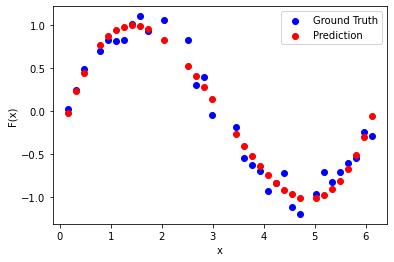

In [281]:
#f(x,w) = w0 + w1x + w2x^2 + ... + wmx^(m-1)
# y = 0->m SUM(wjx^j)

def predict_value(x_query, w):
    
    y = 0
    for coeff in range(len(w)):
        y += w[coeff] * (x_query ** coeff)
        #print(w[coeff][0,0],'*',(x_query ** coeff),'+ ',end='')

    return float(y)


def batch_predict(testing_x, w):

    t_pred = []
    for i in testing_x:
        t_pred.append(predict_value(i, w))

    return np.asarray(t_pred)


def plot_predictions(testing_x, testing_t, t_pred):

    plt.scatter(testing_x, testing_t,color='blue',label='Ground Truth')
    plt.scatter(testing_x, t_pred,color='red',label='Prediction')
    plt.legend()
    plt.ylabel('F(x)')
    plt.xlabel('x')
    plt.show()
    
t_pred = batch_predict(training_x, w)
plot_predictions(training_x, training_t, t_pred)

Root-Mean-Square (RMS) Error (1c)
---

In [282]:
# Sum of Squares Error
# E(w) = 1/2 (phi * w - t).T * (phi * w - t)

def calculate_sos_error(testing_t, t_pred):
    
    E = 0
    for i in range(len(testing_t)):
        E = E + (t_pred[i] - testing_t[i]) ** 2
        
    return E/2


# Root-Mean-Square (RMS) Error
# Erms = sqrt(2E(w*)/N)

def calculate_rms_error(testing_t, t_pred):
    
    E = calculate_sos_error(testing_t, t_pred)
    rms = math.sqrt(2 * E/len(testing_t))
    return rms

print("SOS Error:",calculate_sos_error(testing_t, t_pred))
print("RMS Error:",calculate_rms_error(testing_t, t_pred))

SOS Error: 3.0642051070779646
RMS Error: 0.8752435528294346


Decreasing E(w) with Batch Gradient Descent (2a/b)
---

In [283]:
def gradient_descent_update(training_x, training_t, phi, w, learning_rate):
    
    error_flag = False
    error_sum = 0
    total = np.zeros((len(w),1))
    for sample in range(len(training_x)):
        
        dif = predict_value(training_x[sample], w) - training_t[sample]
        total += dif * phi[sample].T
        error_sum += dif
        
    #if error_sum < 10**-100:
        #error_flag = True
            
    return w - learning_rate * total, error_flag

def iterative_grad_descent(training_x, training_t, phi, w, niterations=3000000, learning_rate=4*10**-7):
    
    rms_error = []
    for iter in range(niterations):
        w,error_flag = gradient_descent_update(training_x, training_t, phi, w, learning_rate)
        t_pred = batch_predict(testing_x, w)
        rms_error.append(calculate_rms_error(testing_t, t_pred))
        
        if error_flag is True:
            break
    
    return w,rms_error

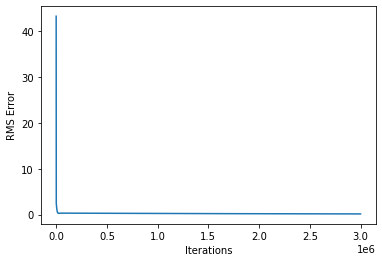

W:
[[ 0.18110206]
 [ 1.30253145]
 [-0.66817211]
 [ 0.07266579]]


In [284]:
w = np.random.rand(m+1,1)
#w = solve_w(phi,training_t)
phi = make_phi(m,training_x)
w,rms_error = iterative_grad_descent(training_x, training_t, phi, w)

plt.plot(rms_error)
plt.ylabel('RMS Error')
plt.xlabel('Iterations')
plt.show()
print('W:')
print(w)

# Prediction with BGD (2c/d/e)
---

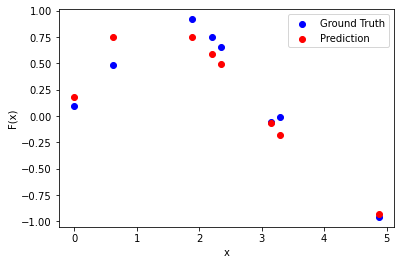

Gradient Descent W:
 [[ 0.18110206]
 [ 1.30253145]
 [-0.66817211]
 [ 0.07266579]]

One-Step W:
 [[-0.32330619]
 [ 2.04504154]
 [-0.92497593]
 [ 0.0976409 ]]

Testing RMS Error: 2.816948450925067


In [286]:
t_pred = batch_predict(testing_x, w)
plot_predictions(testing_x, testing_t, t_pred)

print("Gradient Descent W:\n", w)

print("\nOne-Step W:\n",w_copy) #2e, They're the same before and after BGD

print("\nTesting RMS Error:",calculate_rms_error(testing_x, t_pred))

Task 3 (a/b)
---

In [482]:
m = 11

x,t = gen_data(nsamp=10,noise_stdev=0.1,seed=7)
training_x,training_t,testing_x,testing_t = split_data(x,t,training_size=0.5)

phi = make_phi(m,training_x)
w = solve_w(phi,training_t)

print("Un-Regularized W")
print(w)

t_pred = batch_predict(training_x, w)
print("\nRMS Training Error:",calculate_rms_error(training_t, t_pred))

t_pred = batch_predict(testing_x, w)
print("\nRMS Testing Error:",calculate_rms_error(testing_t, t_pred))

Un-Regularized W
[[-9.61537852e+00]
 [ 3.02656250e+01]
 [-2.35937500e+01]
 [ 2.90234375e+00]
 [-6.99218750e-01]
 [ 8.35937500e-01]
 [-9.28955078e-02]
 [ 6.59179688e-03]
 [-9.94873047e-03]
 [ 5.34057617e-04]
 [ 4.76837158e-05]
 [ 3.02791595e-05]]

RMS Training Error: 6.407699131367491

RMS Testing Error: 1039.7269808729584


3a) Overfitting is occuring when there is a high ratio of coefficients (m) to samples, which leads to a complex high order regression model with very high W values. This occurs because the model too closely follows the exact location of the training data.

Regularization Task 4
---

In [483]:
def regularized_w(m,phi,training_t,lambda_val):
    
    term1 = inv(phi.T * phi + lambda_val * np.identity(m+1))
    term2 = np.dot(phi.T, np.asarray(training_t)).T

    return term1 * term2

lambda_val = math.e**-18
w = regularized_w(m,phi,training_t,lambda_val)

print("Regularized W{")
for el in range(len(w)):
    print(round(w[el][0,0],5),'    ',end='')
print("\n}")

Regularized W{
26.90896     -19.07104     8.0795     -2.17981     0.491     0.09763     -0.16565     0.01511     0.01205     -0.00024     -0.00089     0.00011     
}


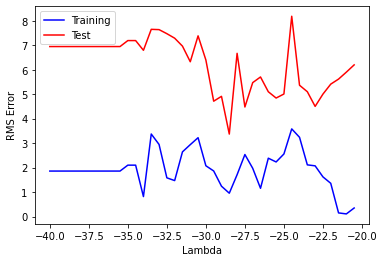


RMS Training Error: 1.4160976944996952

RMS Testing Error: 491.65791112654915


In [485]:
train_errors = []
test_errors = []
lambdas = np.arange(-40,-20,0.5)

for reg_term in lambdas:
    
    lambda_val = math.e**reg_term
    w = regularized_w(m,phi,training_t,lambda_val)
    
    t_pred_train = batch_predict(training_x, w)
    t_pred_test = batch_predict(testing_x, w)
    
    
    train_errors.append(calculate_rms_error(training_t, t_pred_train))
    test_errors.append(calculate_rms_error(testing_t, t_pred_test))
    
log_train_errors = []
for el in train_errors:
    log_train_errors.append(math.log(el))
log_test_errors = []
for el in test_errors:
    log_test_errors.append(math.log(el))
    
plt.plot(lambdas, log_train_errors,color='blue',label='Training')
plt.plot(lambdas, log_test_errors,color='red',label='Test')
plt.ylabel('RMS Error')
plt.xlabel('Lambda')
plt.legend()
plt.show()

t_pred = batch_predict(training_x, w)
print("\nRMS Training Error:",calculate_rms_error(training_t, t_pred))

t_pred = batch_predict(testing_x, w)
print("\nRMS Testing Error:",calculate_rms_error(testing_t, t_pred))

4c) The coefficient of regularization brought the RMS error between the training and testing data much closer together, which indicates it removed some of the overfitting.

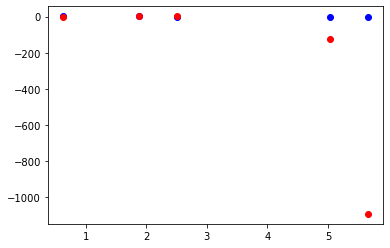

In [486]:
plt.scatter(testing_x,testing_t,color='blue')
plt.scatter(testing_x,t_pred_test,color='red')

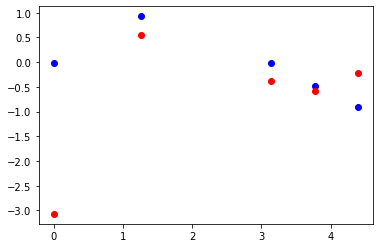

In [487]:
plt.scatter(training_x,training_t,color='blue')
plt.scatter(training_x,t_pred_train,color='red')

Extra Insight: I think the point of this homework was to make me realize how difficult it is to guess which parameters to use with linear regressions, whereas DNNs will save me from this hassle.